# Metrics

## Model and Data preparation

In [53]:
#LIBRARIES
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
from PIL import Image
import torchvision
import torch.nn.functional as F
import cv2
import seaborn as sns
from torchmetrics import ConfusionMatrix
from utils import deprocess_image
from grad_cam import GradCAM
#import networks
torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.8.1+cpu


In [40]:
#VARIABLES

class_names = ['normal', 'viral_pneumonia', 'covid', 'lung_opacity']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)


class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names =  ['normal', 'viral_pneumonia', 'covid', 'lung_opacity']

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

        self.image_dirs = image_dirs
        self.transform = transform


    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])


    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/normal',
    'viral_pneumonia': 'COVID-19_Radiography_Dataset/viral_pneumonia',
    'covid': 'COVID-19_Radiography_Dataset/covid',
    'lung_opacity': 'COVID-19_Radiography_Dataset/lung_opacity'
}
train_dataset = ChestXRayDataset(train_dirs, train_transform)
test_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral_pneumonia': 'COVID-19_Radiography_Dataset/test/viral_pneumonia',
    'covid': 'COVID-19_Radiography_Dataset/test/covid',
    'lung_opacity': 'COVID-19_Radiography_Dataset/test/lung_opacity'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Found 10162 normal examples
Found 1315 viral_pneumonia examples
Found 3586 covid examples
Found 5982 lung_opacity examples
Found 30 normal examples
Found 30 viral_pneumonia examples
Found 30 covid examples
Found 30 lung_opacity examples


In [67]:
#MODEL
model = torch.load('covid_model.pt')

c:\users\desktop\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:589: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


## Data extraction

In [68]:
classes =('Normal','Lung Opacity','Pneumonia','COVID-19')
test_pred_labels = []
test_true_labels = []
train_pred_labels = []
train_true_labels = []
ps_list = []
ps_list_train = []
running_correct = 0.0
running_total = 0.0
running_correct_train = 0.0
running_total_train = 0.0
accuracy_test=0.0
accuracy_train=0.0

def data_extraction(pred_label,true_label,ps_label,dataset,correct,total,accuracy):
    with torch.no_grad():
        for images, labels in dataset:
            model.eval()
            output = model(images)
            ps = F.softmax(output, dim=1)
            output = (torch.max(torch.exp(output), 1)[1]).numpy()
            pred_label.extend(output)
            labels = labels.numpy()
            true_label.extend(labels)
            #ps = ps.data.cpu().numpy().squeeze()
            #ps_label.extend(np.max(ps))
            total += len(labels)
            correct += (output == labels).sum().item()
        accuracy = correct/total
        return pred_label,true_label,ps_label,dataset,correct,total,accuracy

In [71]:
one=data_extraction(test_pred_labels,test_true_labels,ps_list,dl_test,running_correct,running_total,accuracy_test)

target_test = torch.tensor(one[1])
preds_test = torch.tensor(one[0])
confmat = ConfusionMatrix(num_classes=4)
mat_tensor = confmat(preds_test, target_test)
print(mat_tensor)

tensor([[46.,  8.,  0., 19.],
        [ 0., 49.,  0.,  0.],
        [ 2.,  0., 40., 17.],
        [ 0.,  0.,  4., 55.]])


In [ ]:
two=data_extraction(train_pred_labels,train_true_labels,ps_list_train,dl_train,running_correct_train,running_total_train,accuracy_train)

target_train = torch.tensor(two[1])
preds_train = torch.tensor(two[0])
confmat2 = ConfusionMatrix(num_classes=4)
mat_tensor2 = confmat2(preds_train, target_train)

print(mat_tensor2)

## Accuracy for test data

In [72]:
print("Total Correct Images: {}, Total Test Images: {}".format(int(one[4]), int(one[5])))
print("Test Accuracy: ", one[6])

Total Correct Images: 97, Total Test Images: 120
Test Accuracy:  0.8083333333333333


## Confussion Matrix

In [ ]:
def confutio(mat_tensor,name):
    conf_mat = mat_tensor.numpy()
    group_names = ['True Pos Normal','False Neg','False Neg','False Neg',
                   'False Neg','True Pos Lung','False Neg','False Neg',
                   'False Neg','False Neg','True Pos Pneumonia','False Neg',
                   'False Neg','False Neg','False Neg','True Pos COVID']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(4,4)
    fig, ax = plt.subplots(figsize=(10,10))
    ax=sns.heatmap(conf_mat, annot=labels, fmt='',ax=ax)
    ax.set_title(label=name+' Confussion Matrix')
    ax.plot
    fig.savefig(name+'_confussion.png')

### Confussion Matrix Test

In [ ]:
confutio(mat_tensor,'Test')

### Confussion Matrix Train

In [ ]:
confutio(mat_tensor2,'Train')

## Precision, Recall, F1 Score & Support

In [ ]:
import sklearn.metrics as metrics
print("Classification report for test set:\n%s\n"
      % (metrics.classification_report(one[1], one[0],target_names=["Normal","Lung opacity","Pneumonia","COVID-19"])))

## GradCAM

In [49]:
#GRADCAM FUNCTIONS
def apply_mask(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def plot_gradcam(image, res_cam):
    image = deprocess_image(image)
    name_dict = {
        'Original Image': image,

        'GradCAM (ResNet-18)': apply_mask(image, res_cam)

    }

    plt.style.use('seaborn-notebook')
    fig = plt.figure(figsize=(10, 4))
    for i, (name, img) in enumerate(name_dict.items()):
        ax = fig.add_subplot(1, 2, i+1, xticks=[], yticks=[])
        if i:
            img = img[:, :, ::-1]
        ax.imshow(img)
        ax.set_xlabel(name, fontweight='bold')

    fig.suptitle(
        'Localization with Gradient based Class Activation Maps',
        fontweight='bold', fontsize=16
    )
    plt.tight_layout()
    fig.savefig('grad_cam.png')
    plt.show()
    plt.close()


def show_images2(images, labels, preds,res_cam):
    plt.figure(figsize=(20,10))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        #image = image.numpy().transpose((1, 2, 0))
        image = image.cpu().numpy()
        image=np.squeeze(np.transpose(image, (1, 2, 0)))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        image=apply_mask(image, res_cam[i][1])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_resnet18(pretrained=False, out_features=None, path=None):
    model = torchvision.models.resnet18(pretrained=pretrained)
    if out_features is not None:
        model.fc = torch.nn.Linear(in_features=512, out_features=out_features)
    if path is not None:
        model.load_state_dict(torch.load(path, map_location=device))

    return model.to(device)

c:\users\desktop\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


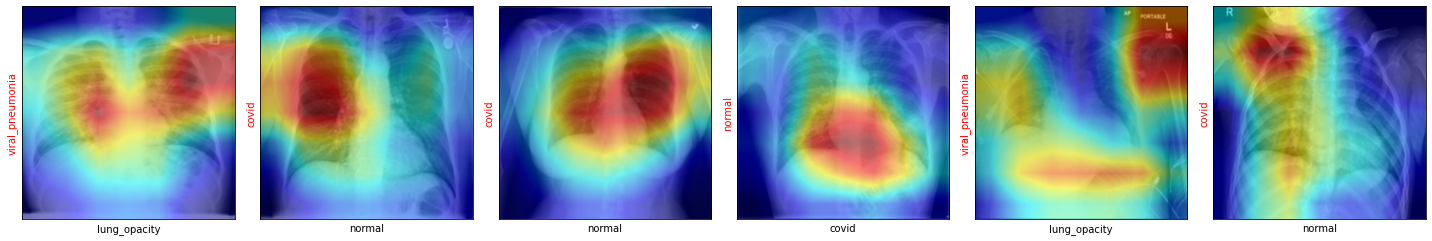

In [60]:
#GRADCAM PLOT


res_cam=[]
model.eval()
images, labels = next(iter(dl_test))
outputs = model(images)
_, preds = torch.max(outputs, 1)
resnet18 = get_resnet18(out_features=4, path='bairu.pth')
cam_obj = GradCAM(model=resnet18, target_layer=resnet18.layer4[-1])
for x,image in enumerate (images):
    image=image.unsqueeze(dim=0).cpu()
    res_cam.append(cam_obj(image, int(labels[x].numpy())))


show_images2(images,labels,preds,res_cam)
#plot_gradcam(images[0].unsqueeze(dim=0).cpu(),res_cam[0][1])